In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import Lottery, plot_values


torch.manual_seed(12046)

In [2]:
# 收集数据
states = []
rewards = []
game = Lottery()
for _ in range(1000):
    s = game.reset()
    done = False
    one_game_state = []
    one_game_reward = []
    while not done:
        # 简单定义策略一直玩
        action = 1
        next_s, r = game.step(action)
        one_game_state.append(s)
        one_game_reward.append(r)
        s = next_s
        if next_s == 't':
            done = True
    states.append(one_game_state)
    rewards.append(one_game_reward)

In [3]:
def compute_cum_rewards(r, gamma):
    cum_rewards = 0
    for j in reversed(r):
        cum_rewards = j + cum_rewards * gamma
    return cum_rewards

compute_cum_rewards(torch.normal(1, 1, (100,)), 0.9)

tensor(10.0801)

In [4]:
# Monte Carlo Learning & # Temporal Difference Learning params
gamma = 0.9
alpha = 0.01
# NN params
learning_rate = 0.01
lambda_ = 0.95

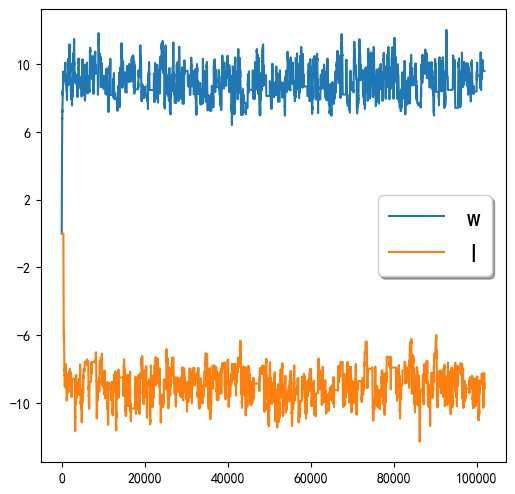

In [5]:
# Monte Carlo Learning
v = [{'w': 0.0, 'l': 0.0}]

for s, r in zip(states, rewards):
    if len(s) == 0:
        continue
    # 将一个回合拆分成n个回合
    for i in range(len(s)):
        values = copy.deepcopy(v[-1])
        # 此处可以加上首次出现（Exploring Starts）的筛选
        G = compute_cum_rewards(r[i:], gamma)
        advantage = G - values[s[i]]
        vt = values[s[i]]
        values[s[i]] = vt + alpha * advantage
        v.append(values)

fig = plot_values(v)
fig.savefig('mc_learning.png', dpi=200)

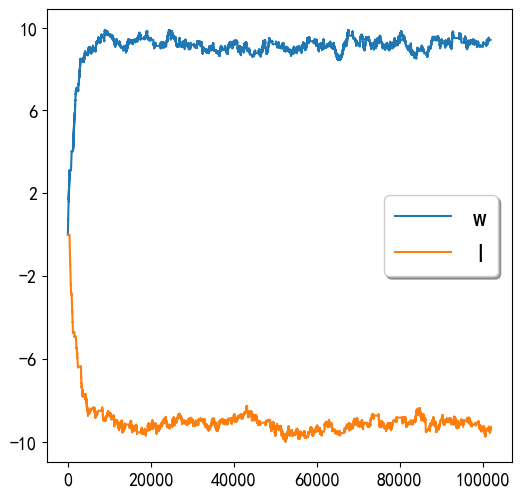

In [6]:
# Temporal Difference Learning
v = [{'w': 0.0, 'l': 0.0}]

for s, r in zip(states, rewards):
    if len(s) == 0:
        continue
    for i in range(len(s)):
        values = copy.deepcopy(v[-1])
        vt_next = values[s[i + 1]] if i < len(s) - 1 else 0
        G = r[i] + gamma * vt_next
        advantage = G - values[s[i]]
        vt = values[s[i]]
        values[s[i]] = vt + alpha * advantage
        v.append(values)

fig = plot_values(v)
fig.savefig('td_learning.png', dpi=200)

In [7]:
class VQN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(2, 4)
        self.ln = nn.Linear(4, 1)
        # 为了方便对比，固定初始化参数初始化
        for p in self.parameters():
            if p.ndimension() != 2:
                torch.nn.init.zeros_(p)
            else:
                torch.nn.init.eye_(p)

    def forward(self, x):
        ref = {'w': 0, 'l': 1}
        x = torch.tensor(ref[x])
        x = F.relu(self.emb(x))
        x = self.ln(x)
        return x

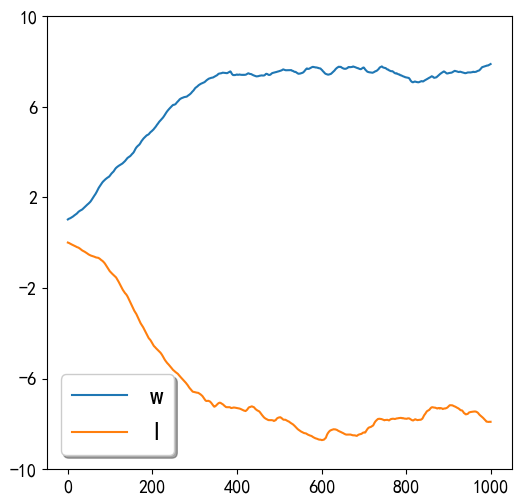

In [8]:
# Monte Carlo Learning
model = VQN()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
v = []

for s, r in zip(states, rewards):
    if len(s) == 0:
        continue
    loss = 0.0
    optimizer.zero_grad()
    for i in range(len(s)):
        # 此处可以加上首次出现（Exploring Starts）的筛选
        with torch.no_grad():
            G = compute_cum_rewards(r[i:], gamma)
            advantage = G - model(s[i])
        vt = model(s[i])
        loss += -advantage * vt
        # 上面对loss的定义等价于：loss = 0.5 * (G - vt) ** 2
    loss /= len(s)
    loss.backward()
    optimizer.step()
    # 记录模型效果
    v.append({'w': model('w').item(), 'l': model('l').item()})

fig = plot_values(v)

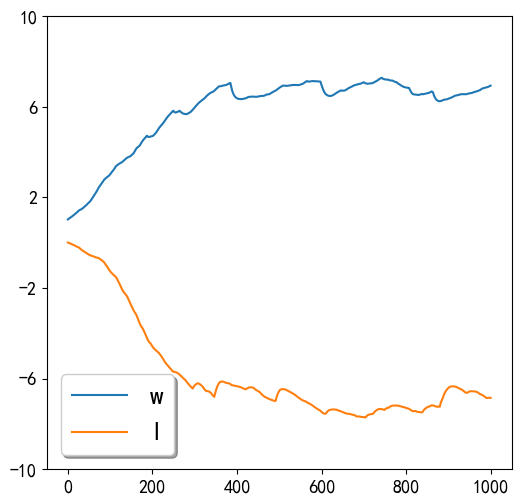

In [9]:
# Temporal Difference Learning
model = VQN()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
v = []

for s, r in zip(states, rewards):
    if len(s) == 0:
        continue
    loss = 0.0
    optimizer.zero_grad()
    for i in range(len(s)):
        with torch.no_grad():
            vt_next = model(s[i + 1]) if i < len(s) - 1 else 0
            G = r[i] + gamma * vt_next
            advantage = G - model(s[i])
        vt = model(s[i])
        loss += -advantage * vt
        # 上面对loss的定义等价于：loss = 0.5 * (G - vt) ** 2
    loss /= len(s)
    loss.backward()
    optimizer.step()
    # 记录模型效果
    v.append({'w': model('w').item(), 'l': model('l').item()})

fig = plot_values(v)

In [10]:
class GAE:

    def __init__(self, gamma, lambda_):
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, rewards, values):
        # advantages table
        advantages = []
        last_advantage = 0
        vt_next = 0
        for r, vt in zip(reversed(rewards), reversed(values)):
            delta = r + self.gamma * vt_next - vt
            last_advantage = delta + self.gamma * self.lambda_ * last_advantage
            advantages.insert(0, last_advantage)
            vt_next = vt

        return advantages

In [11]:
s = states[-1]
r = rewards[-1]
values = [model(i).item() for i in s]
# 验证gamma=1时，gae等同于mc learning
mc_advantage = []
for i in range(len(r)):
    G = compute_cum_rewards(r[i:], gamma)
    mc_advantage.append(G - values[i])
gae = GAE(gamma, 1)
gae_advantage = torch.tensor(gae(r, values))
torch.abs(torch.tensor(mc_advantage) - gae_advantage) < 1e-4

tensor([True, True, True, True, True, True, True, True, True])

In [12]:
# 验证gamma=0时，gae等同于td learning
vt_next = values[:-1] + [0.0]
td_advantage = torch.tensor(r) + gamma * torch.tensor(vt_next) - torch.tensor(values)
gae = GAE(gamma, 0)
gae_advantage = torch.tensor(gae(r, values))
torch.abs(td_advantage - gae_advantage) < 1e-4

tensor([True, True, True, True, True, True, True, True, True])

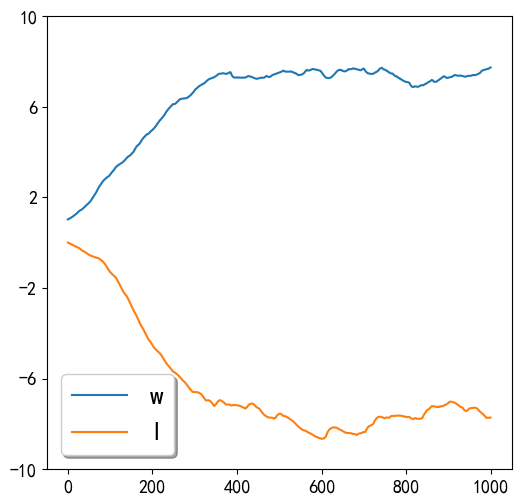

In [13]:
# GAE
model = VQN()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
v = []
gae = GAE(gamma, lambda_)

for s, r in zip(states, rewards):
    if len(s) == 0:
        continue
    optimizer.zero_grad()
    with torch.no_grad():
        values = [model(_state).item() for _state in s]
        advantages = torch.tensor(gae(r, values))
    vpred = torch.concat([model(_state) for _state in s], dim=0)
    loss = torch.mean(-advantages * vpred)
    loss.backward()
    optimizer.step()
    # 记录模型效果
    v.append({'w': model('w').item(), 'l': model('l').item()})
    
fig = plot_values(v)